In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

2023-03-24 17:05:52.496356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 17:05:52.992631: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-24 17:05:52.992718: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-24 17:05:55.907720: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinf

In [2]:
df = pd.read_csv("../data/processed_its_top_10.csv")[-6000:]
df["description"] = df["description"].fillna("")
X = df["description"].fillna("None").to_numpy()
le = LabelEncoder()
y = le.fit_transform(df["service_offering"])
num_classes = len(le.classes_)
# Use the following line if you plan to use CategoricalCrossentropy as the loss function
# y = tf.keras.utils.to_categorical(y, num_classes=num_classes)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [3]:
df.head()

,Unnamed: 0,description,service_offering
363699,900771,Call answered by: Grace Garber,Other
363700,900772,"Hi Claudio,\r\nAs I'm waiting for Soo to gen...",Other
363701,900777,"received from: j7jang@ucsd.edu\n\nHello, my na...",MultiFactor Authentication
363702,900779,We received your CINFO request for AWS resourc...,Other
363703,900780,received from: stanleyyang22@gmail.com\n\nHell...,Other


<AxesSubplot:ylabel='service_offering'>

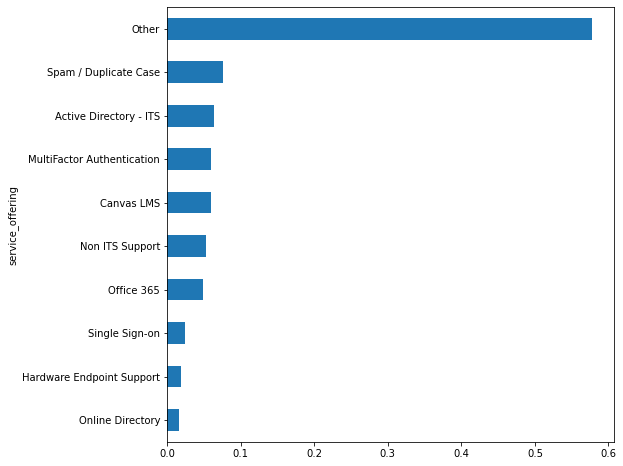

In [4]:
(df.groupby(df["service_offering"])["description"].count() / df.shape[0]).sort_values().plot(kind="barh", figsize=(8,8))

In [5]:
new_model = tf.keras.models.load_model('saved_model/my_model', compile=False)
new_model.summary()

2023-03-24 17:06:17.156712: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-24 17:06:17.157286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-24 17:06:17.157531: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-24 17:06:17.157737: W tensorflow/compiler/xla/stream_executor/platform/defa

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [12]:
# Sparse Categorical Cross Entropy and F1 Score
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = tf.keras.metrics.CategoricalAccuracy()

In [13]:
epochs = 20
steps_per_epoch = 1000
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw"
)

In [15]:
new_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

In [6]:
predictions = new_model.predict(X_train)

150/150 [==============================] - 69s 458ms/step


In [7]:
final_pred = np.argmax(predictions, axis=1)

In [8]:
np.mean(final_pred==y_train)

0.08604166666666667

In [116]:
test = [
    "received from: efgrossm@eng.ucsd.edu Hi UCSD service desk,I am trying to access MyStudentChart, but my phone broke yesterday. I cannot use DuoMobile to confirm login from my computer. Can I get a bypass code while I wait for my new phone to come? -Esther"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 76ms/step


array(['Non ITS Support'], dtype=object)

In [9]:
test = [
    "received from: efgrossm@eng.ucsd.edu Hi UCSD service desk,I am trying to access MyStudentChart, but my phone broke yesterday. I cannot use DuoMobile to confirm login from my computer. Can I get a bypass code while I wait for my new phone to come? -Esther"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 461ms/step


array(['Non ITS Support'], dtype=object)

In [80]:
test = [
    """received from: rsotelo@ucsd.edu

Hi Service desk,

Can you please help me register my era commons username RYSOTELO and USCD affiliation to DUO.

Thank you,

Raquel
"""]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 84ms/step


array(['MultiFactor Authentication'], dtype=object)

In [81]:
test = ["My account is compromised, I need to change my password"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 80ms/step


array(['Active Directory - ITS'], dtype=object)

In [82]:
test = ["My Duo Mobile app is not working and I can't ask it to call me anymore."]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 77ms/step


array(['MultiFactor Authentication'], dtype=object)

In [83]:
test = ["Wifi at Sixth college is not working. All of my friends are reporting a problem"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 78ms/step


array(['Other'], dtype=object)

In [84]:
test = ["My VPN is not working. It is stuck on trying to connect when I type in my password"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 72ms/step


array(['Other'], dtype=object)

In [85]:
test = ["I am not receiving any emails in my Outlook exchange. The last email I got was 2 months ago. HELP!!!"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 84ms/step


array(['Other'], dtype=object)

In [86]:
test = ["I need to register my Microsoft Exchange account. I can't receive any emails as of right now."]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 75ms/step


array(['Active Directory - ITS'], dtype=object)

In [87]:
test = ["I just registered for Math 189 yesterday and it is not showing up as a course on my Canvas page. Please help"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 75ms/step


array(['Canvas LMS'], dtype=object)

In [88]:
test = ["My docking station is broken, the monitors connected to it does not work"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 90ms/step


array(['Other'], dtype=object)

In [89]:
test = ["My laptop is not turning on and I have work today. Please help ASAP"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 77ms/step


array(['Hardware Endpoint Support'], dtype=object)

In [90]:
test = ["My health email is not receiving any emails, what is going on?"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 74ms/step


array(['Other'], dtype=object)

In [91]:
test = ["I need Adobe Acrobat for work, how can I get that on my account?"]
pred = np.argmax(new_model.predict(x = test))
le.inverse_transform([pred])

1/1 [==============================] - 0s 78ms/step


array(['Enterprise Software Licensing Support'], dtype=object)